<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 17.7MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 38.2MB 68kB/s 
     |████████████████████████████████| 952kB 35.5MB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Download model
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/normal.pth', 'normal.pth')

In [2]:
# Download dataset stereo
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2853      0 --:--:-- --:--:-- --:--:--  2853
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1279M    0 1279M    0     0  74.8M      0 --:--:--  0:00:17 --:--:--  105M
Completed in 44 seconds


In [2]:
!git pull
!python dataset.py
!python model.py

Updating c07b8a8..d6d7fab
Fast-forward
 data/out/0000.exr | Bin 261382 -> 542170 bytes
 data/out/0000.png | Bin 159600 -> 220321 bytes
 data/out/0001.exr | Bin 191314 -> 194156 bytes
 data/out/0001.png | Bin 37993 -> 53230 bytes
 data/out/0002.exr | Bin 256068 -> 281186 bytes
 data/out/0002.png | Bin 135194 -> 358123 bytes
 detect.py         |   2 +-
 util.py           |  11 +++++++++--
 8 files changed, 10 insertions(+), 3 deletions(-)
dataset ok
model ok


In [5]:
import os
import re
import cv2
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [
    {
      "imageL": "data/0000L.png",
      "imageR": "data/0000R.png",
      "output": "data/out/0000.exr",
    },
    {
      "imageL": "data/0001L.png",
      "imageR": "data/0001R.png",
      "output": "data/out/0001.exr",
    },
    {
      "imageL": "data/0002L.png",
      "imageR": "data/0002R.png",
      "output": "data/out/0002.exr",
    }
]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
DAMPENING = 0.1

MILESTONES = [10,20,30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [6]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

detect_transform = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_SIZE),
            A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.Normalize(),
            M.MyToTensorV2(),
        ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [8]:
model = Model()
model.apply(init_weights)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=LEARNING_RATE, momentum=MOMENTUM,
                         dampening = DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [8]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:0.0716)
======DEPTH=======
MSE=0.1086	RMSE=0.3120	MAE=0.1484	ABS_REL=0.1496
DELTA1.02=0.2169	DELTA1.05=0.4542	DELTA1.10=0.7319
DELTA1.25=0.8970	DELTA1.25^2=0.9455	DELTA1.25^3=0.9640



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:0.0583)
======DEPTH=======
MSE=0.0698	RMSE=0.2482	MAE=0.0876	ABS_REL=0.0878
DELTA1.02=0.4418	DELTA1.05=0.7705	DELTA1.10=0.9002
DELTA1.25=0.9527	DELTA1.25^2=0.9709	DELTA1.25^3=0.9810



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:0.0700)
======DEPTH=======
MSE=0.0485	RMSE=0.2055	MAE=0.0650	ABS_REL=0.0653
DELTA1.02=0.4614	DELTA1.05=0.8493	DELTA1.10=0.9490
DELTA1.25=0.9714	DELTA1.25^2=0.9821	DELTA1.25^3=0.9870



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:0.0439)
======DEPTH=======
MSE=0.0388	RMSE=0.1831	MAE=0.0535	ABS_REL=0.0538
DELTA1.02=0.5487	DELTA1.05=0.8672	DELTA1.10=0.9608
DELTA1.25=0.9794	DELTA1.25^2=0.9866	DELTA1.25^3=0.9907



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:0.3652)
======DEPTH=======
MSE=0.0345	RMSE=0.1732	MAE=0.0501	ABS_REL=0.0507
DELTA1.02=0.5261	DELTA1.05=0.8911	DELTA1.10=0.9642
DELTA1.25=0.9825	DELTA1.25^2=0.9885	DELTA1.25^3=0.9917



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:0.0627)
======DEPTH=======
MSE=0.0523	RMSE=0.2109	MAE=0.0587	ABS_REL=0.0589
DELTA1.02=0.6250	DELTA1.05=0.9272	DELTA1.10=0.9638
DELTA1.25=0.9767	DELTA1.25^2=0.9844	DELTA1.25^3=0.9886



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:0.7180)
======DEPTH=======
MSE=0.0378	RMSE=0.1829	MAE=0.0476	ABS_REL=0.0479
DELTA1.02=0.6318	DELTA1.05=0.9346	DELTA1.10=0.9721
DELTA1.25=0.9820	DELTA1.25^2=0.9878	DELTA1.25^3=0.9913



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:0.0437)
======DEPTH=======
MSE=0.0428	RMSE=0.1887	MAE=0.0501	ABS_REL=0.0505
DELTA1.02=0.6910	DELTA1.05=0.9179	DELTA1.10=0.9675
DELTA1.25=0.9803	DELTA1.25^2=0.9863	DELTA1.25^3=0.9896



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:0.0556)
======DEPTH=======
MSE=0.0287	RMSE=0.1618	MAE=0.0411	ABS_REL=0.0412
DELTA1.02=0.6331	DELTA1.05=0.9349	DELTA1.10=0.9770
DELTA1.25=0.9855	DELTA1.25^2=0.9901	DELTA1.25^3=0.9927



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:0.1240)
======DEPTH=======
MSE=0.0531	RMSE=0.2053	MAE=0.0634	ABS_REL=0.0637
DELTA1.02=0.5355	DELTA1.05=0.8663	DELTA1.10=0.9610
DELTA1.25=0.9769	DELTA1.25^2=0.9847	DELTA1.25^3=0.9894



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:0.0468)
======DEPTH=======
MSE=0.0368	RMSE=0.1776	MAE=0.0349	ABS_REL=0.0354
DELTA1.02=0.9347	DELTA1.05=0.9657	DELTA1.10=0.9755
DELTA1.25=0.9831	DELTA1.25^2=0.9888	DELTA1.25^3=0.9920



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:0.0435)
======DEPTH=======
MSE=0.0365	RMSE=0.1740	MAE=0.0333	ABS_REL=0.0341
DELTA1.02=0.9442	DELTA1.05=0.9708	DELTA1.10=0.9788
DELTA1.25=0.9852	DELTA1.25^2=0.9893	DELTA1.25^3=0.9920



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:0.0369)
======DEPTH=======
MSE=0.0332	RMSE=0.1679	MAE=0.0313	ABS_REL=0.0316
DELTA1.02=0.9490	DELTA1.05=0.9718	DELTA1.10=0.9781
DELTA1.25=0.9841	DELTA1.25^2=0.9886	DELTA1.25^3=0.9915



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:0.0847)
======DEPTH=======
MSE=0.0309	RMSE=0.1628	MAE=0.0289	ABS_REL=0.0290
DELTA1.02=0.9553	DELTA1.05=0.9747	DELTA1.10=0.9813
DELTA1.25=0.9867	DELTA1.25^2=0.9905	DELTA1.25^3=0.9928



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:0.0321)
======DEPTH=======
MSE=0.0255	RMSE=0.1533	MAE=0.0255	ABS_REL=0.0258
DELTA1.02=0.9588	DELTA1.05=0.9761	DELTA1.10=0.9823
DELTA1.25=0.9869	DELTA1.25^2=0.9907	DELTA1.25^3=0.9931



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:0.0379)
======DEPTH=======
MSE=0.0238	RMSE=0.1517	MAE=0.0253	ABS_REL=0.0255
DELTA1.02=0.9527	DELTA1.05=0.9736	DELTA1.10=0.9811
DELTA1.25=0.9873	DELTA1.25^2=0.9912	DELTA1.25^3=0.9934



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:0.0352)
======DEPTH=======
MSE=0.0234	RMSE=0.1494	MAE=0.0238	ABS_REL=0.0243
DELTA1.02=0.9578	DELTA1.05=0.9753	DELTA1.10=0.9814
DELTA1.25=0.9866	DELTA1.25^2=0.9910	DELTA1.25^3=0.9932



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:0.0451)
======DEPTH=======
MSE=0.0221	RMSE=0.1460	MAE=0.0227	ABS_REL=0.0232
DELTA1.02=0.9623	DELTA1.05=0.9783	DELTA1.10=0.9835
DELTA1.25=0.9879	DELTA1.25^2=0.9917	DELTA1.25^3=0.9938



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:0.0362)
======DEPTH=======
MSE=0.0209	RMSE=0.1431	MAE=0.0213	ABS_REL=0.0218
DELTA1.02=0.9636	DELTA1.05=0.9786	DELTA1.10=0.9843
DELTA1.25=0.9886	DELTA1.25^2=0.9918	DELTA1.25^3=0.9939



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 19, loss=(total:0.0351)
======DEPTH=======
MSE=0.0201	RMSE=0.1403	MAE=0.0206	ABS_REL=0.0215
DELTA1.02=0.9661	DELTA1.05=0.9795	DELTA1.10=0.9843
DELTA1.25=0.9885	DELTA1.25^2=0.9920	DELTA1.25^3=0.9940



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 20, loss=(total:0.0273)
======DEPTH=======
MSE=0.0207	RMSE=0.1408	MAE=0.0203	ABS_REL=0.0207
DELTA1.02=0.9689	DELTA1.05=0.9798	DELTA1.10=0.9846
DELTA1.25=0.9883	DELTA1.25^2=0.9913	DELTA1.25^3=0.9932



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 21, loss=(total:0.0336)
======DEPTH=======
MSE=0.0209	RMSE=0.1426	MAE=0.0200	ABS_REL=0.0208
DELTA1.02=0.9684	DELTA1.05=0.9807	DELTA1.10=0.9851
DELTA1.25=0.9891	DELTA1.25^2=0.9921	DELTA1.25^3=0.9941



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 22, loss=(total:0.0394)
======DEPTH=======
MSE=0.0208	RMSE=0.1426	MAE=0.0200	ABS_REL=0.0200
DELTA1.02=0.9685	DELTA1.05=0.9808	DELTA1.10=0.9852
DELTA1.25=0.9889	DELTA1.25^2=0.9920	DELTA1.25^3=0.9941



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 23, loss=(total:0.0377)
======DEPTH=======
MSE=0.0205	RMSE=0.1418	MAE=0.0197	ABS_REL=0.0204
DELTA1.02=0.9703	DELTA1.05=0.9808	DELTA1.10=0.9851
DELTA1.25=0.9889	DELTA1.25^2=0.9922	DELTA1.25^3=0.9941



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 24, loss=(total:0.0804)
======DEPTH=======
MSE=0.0200	RMSE=0.1400	MAE=0.0196	ABS_REL=0.0198
DELTA1.02=0.9696	DELTA1.05=0.9808	DELTA1.10=0.9854
DELTA1.25=0.9889	DELTA1.25^2=0.9921	DELTA1.25^3=0.9941



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 25, loss=(total:0.0228)
======DEPTH=======
MSE=0.0197	RMSE=0.1391	MAE=0.0190	ABS_REL=0.0196
DELTA1.02=0.9708	DELTA1.05=0.9820	DELTA1.10=0.9862
DELTA1.25=0.9897	DELTA1.25^2=0.9926	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 26, loss=(total:0.0259)
======DEPTH=======
MSE=0.0204	RMSE=0.1406	MAE=0.0197	ABS_REL=0.0207
DELTA1.02=0.9688	DELTA1.05=0.9806	DELTA1.10=0.9855
DELTA1.25=0.9892	DELTA1.25^2=0.9922	DELTA1.25^3=0.9942



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 27, loss=(total:0.0400)
======DEPTH=======
MSE=0.0198	RMSE=0.1394	MAE=0.0190	ABS_REL=0.0195
DELTA1.02=0.9707	DELTA1.05=0.9818	DELTA1.10=0.9858
DELTA1.25=0.9895	DELTA1.25^2=0.9925	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 28, loss=(total:0.0436)
======DEPTH=======
MSE=0.0198	RMSE=0.1396	MAE=0.0191	ABS_REL=0.0195
DELTA1.02=0.9701	DELTA1.05=0.9812	DELTA1.10=0.9859
DELTA1.25=0.9894	DELTA1.25^2=0.9924	DELTA1.25^3=0.9943



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 29, loss=(total:0.0267)
======DEPTH=======
MSE=0.0204	RMSE=0.1400	MAE=0.0195	ABS_REL=0.0210
DELTA1.02=0.9715	DELTA1.05=0.9821	DELTA1.10=0.9862
DELTA1.25=0.9895	DELTA1.25^2=0.9924	DELTA1.25^3=0.9942



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 30, loss=(total:0.0336)
======DEPTH=======
MSE=0.0202	RMSE=0.1394	MAE=0.0190	ABS_REL=0.0193
DELTA1.02=0.9717	DELTA1.05=0.9824	DELTA1.10=0.9862
DELTA1.25=0.9898	DELTA1.25^2=0.9926	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 31, loss=(total:0.0263)
======DEPTH=======
MSE=0.0196	RMSE=0.1382	MAE=0.0186	ABS_REL=0.0191
DELTA1.02=0.9717	DELTA1.05=0.9826	DELTA1.10=0.9865
DELTA1.25=0.9897	DELTA1.25^2=0.9925	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 32, loss=(total:0.0310)
======DEPTH=======
MSE=0.0199	RMSE=0.1384	MAE=0.0189	ABS_REL=0.0189
DELTA1.02=0.9708	DELTA1.05=0.9817	DELTA1.10=0.9859
DELTA1.25=0.9893	DELTA1.25^2=0.9925	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 33, loss=(total:0.0333)
======DEPTH=======
MSE=0.0198	RMSE=0.1394	MAE=0.0189	ABS_REL=0.0190
DELTA1.02=0.9702	DELTA1.05=0.9818	DELTA1.10=0.9859
DELTA1.25=0.9895	DELTA1.25^2=0.9923	DELTA1.25^3=0.9942



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 34, loss=(total:0.0290)
======DEPTH=======
MSE=0.0217	RMSE=0.1397	MAE=0.0198	ABS_REL=0.0204
DELTA1.02=0.9706	DELTA1.05=0.9814	DELTA1.10=0.9858
DELTA1.25=0.9895	DELTA1.25^2=0.9926	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 35, loss=(total:0.0240)
======DEPTH=======
MSE=0.0206	RMSE=0.1403	MAE=0.0196	ABS_REL=0.0202
DELTA1.02=0.9712	DELTA1.05=0.9815	DELTA1.10=0.9854
DELTA1.25=0.9888	DELTA1.25^2=0.9917	DELTA1.25^3=0.9937



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 36, loss=(total:0.0290)
======DEPTH=======
MSE=0.0195	RMSE=0.1382	MAE=0.0187	ABS_REL=0.0196
DELTA1.02=0.9709	DELTA1.05=0.9818	DELTA1.10=0.9859
DELTA1.25=0.9894	DELTA1.25^2=0.9923	DELTA1.25^3=0.9942



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 37, loss=(total:0.0278)
======DEPTH=======
MSE=0.0191	RMSE=0.1373	MAE=0.0183	ABS_REL=0.0196
DELTA1.02=0.9721	DELTA1.05=0.9825	DELTA1.10=0.9865
DELTA1.25=0.9897	DELTA1.25^2=0.9925	DELTA1.25^3=0.9944



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 38, loss=(total:0.0315)
======DEPTH=======
MSE=0.0196	RMSE=0.1386	MAE=0.0187	ABS_REL=0.0193
DELTA1.02=0.9721	DELTA1.05=0.9820	DELTA1.10=0.9859
DELTA1.25=0.9895	DELTA1.25^2=0.9924	DELTA1.25^3=0.9943



100%|██████████| 309/309 [02:27<00:00,  2.10it/s, epoch=39, loss=(total:0.0215)]

eval_avg_error
Epoch: 39, loss=(total:0.0215)
======DEPTH=======
MSE=0.0202	RMSE=0.1397	MAE=0.0191	ABS_REL=0.0192
DELTA1.02=0.9714	DELTA1.05=0.9816	DELTA1.10=0.9860
DELTA1.25=0.9896	DELTA1.25^2=0.9925	DELTA1.25^3=0.9943



In [9]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 155/155 [00:25<00:00,  6.16it/s]

eval_avg_error
Epoch: 39, loss=(total:0.2678)
======DEPTH=======
MSE=0.0199	RMSE=0.1368	MAE=0.0196	ABS_REL=0.0343
DELTA1.02=0.9704	DELTA1.05=0.9800	DELTA1.10=0.9841
DELTA1.25=0.9876	DELTA1.25^2=0.9907	DELTA1.25^3=0.9929



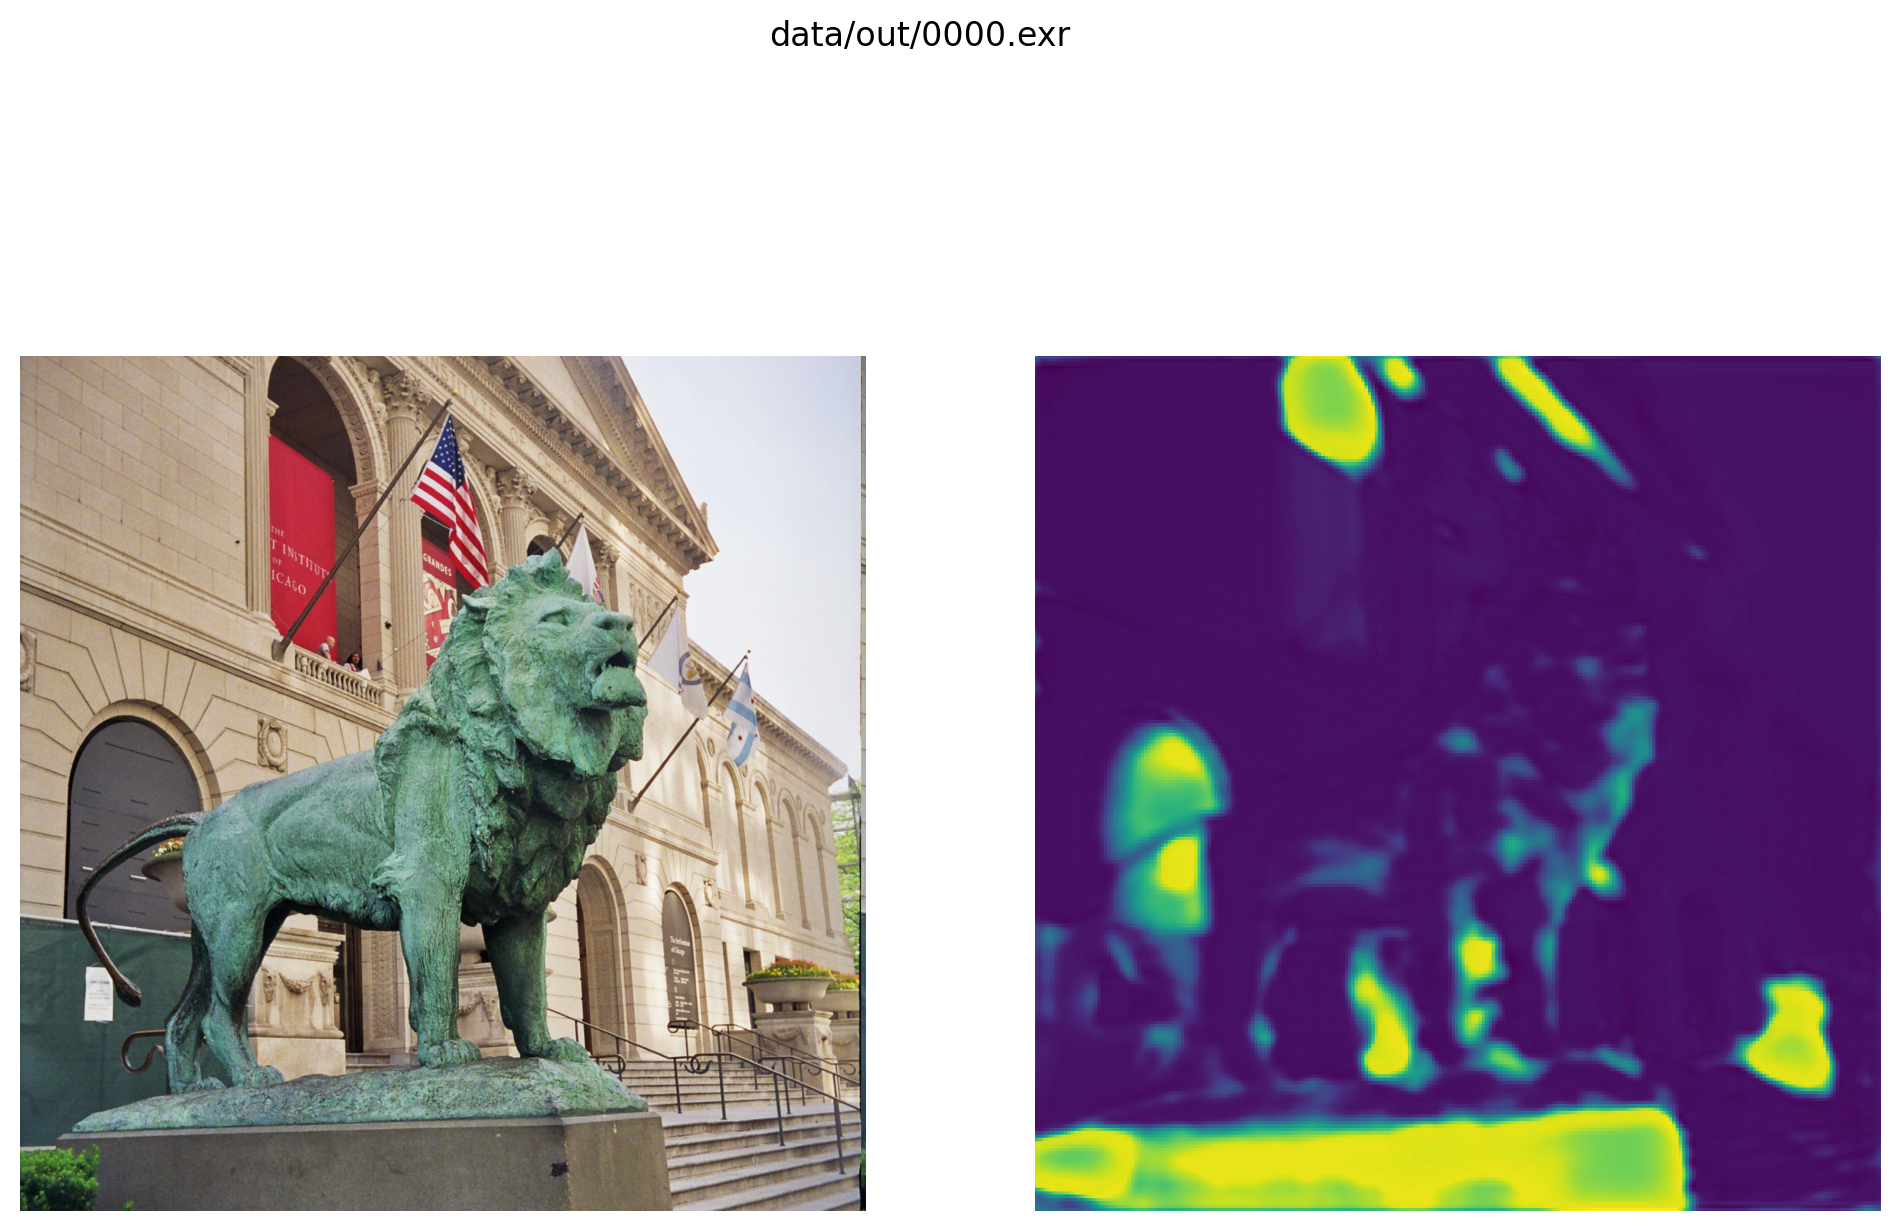

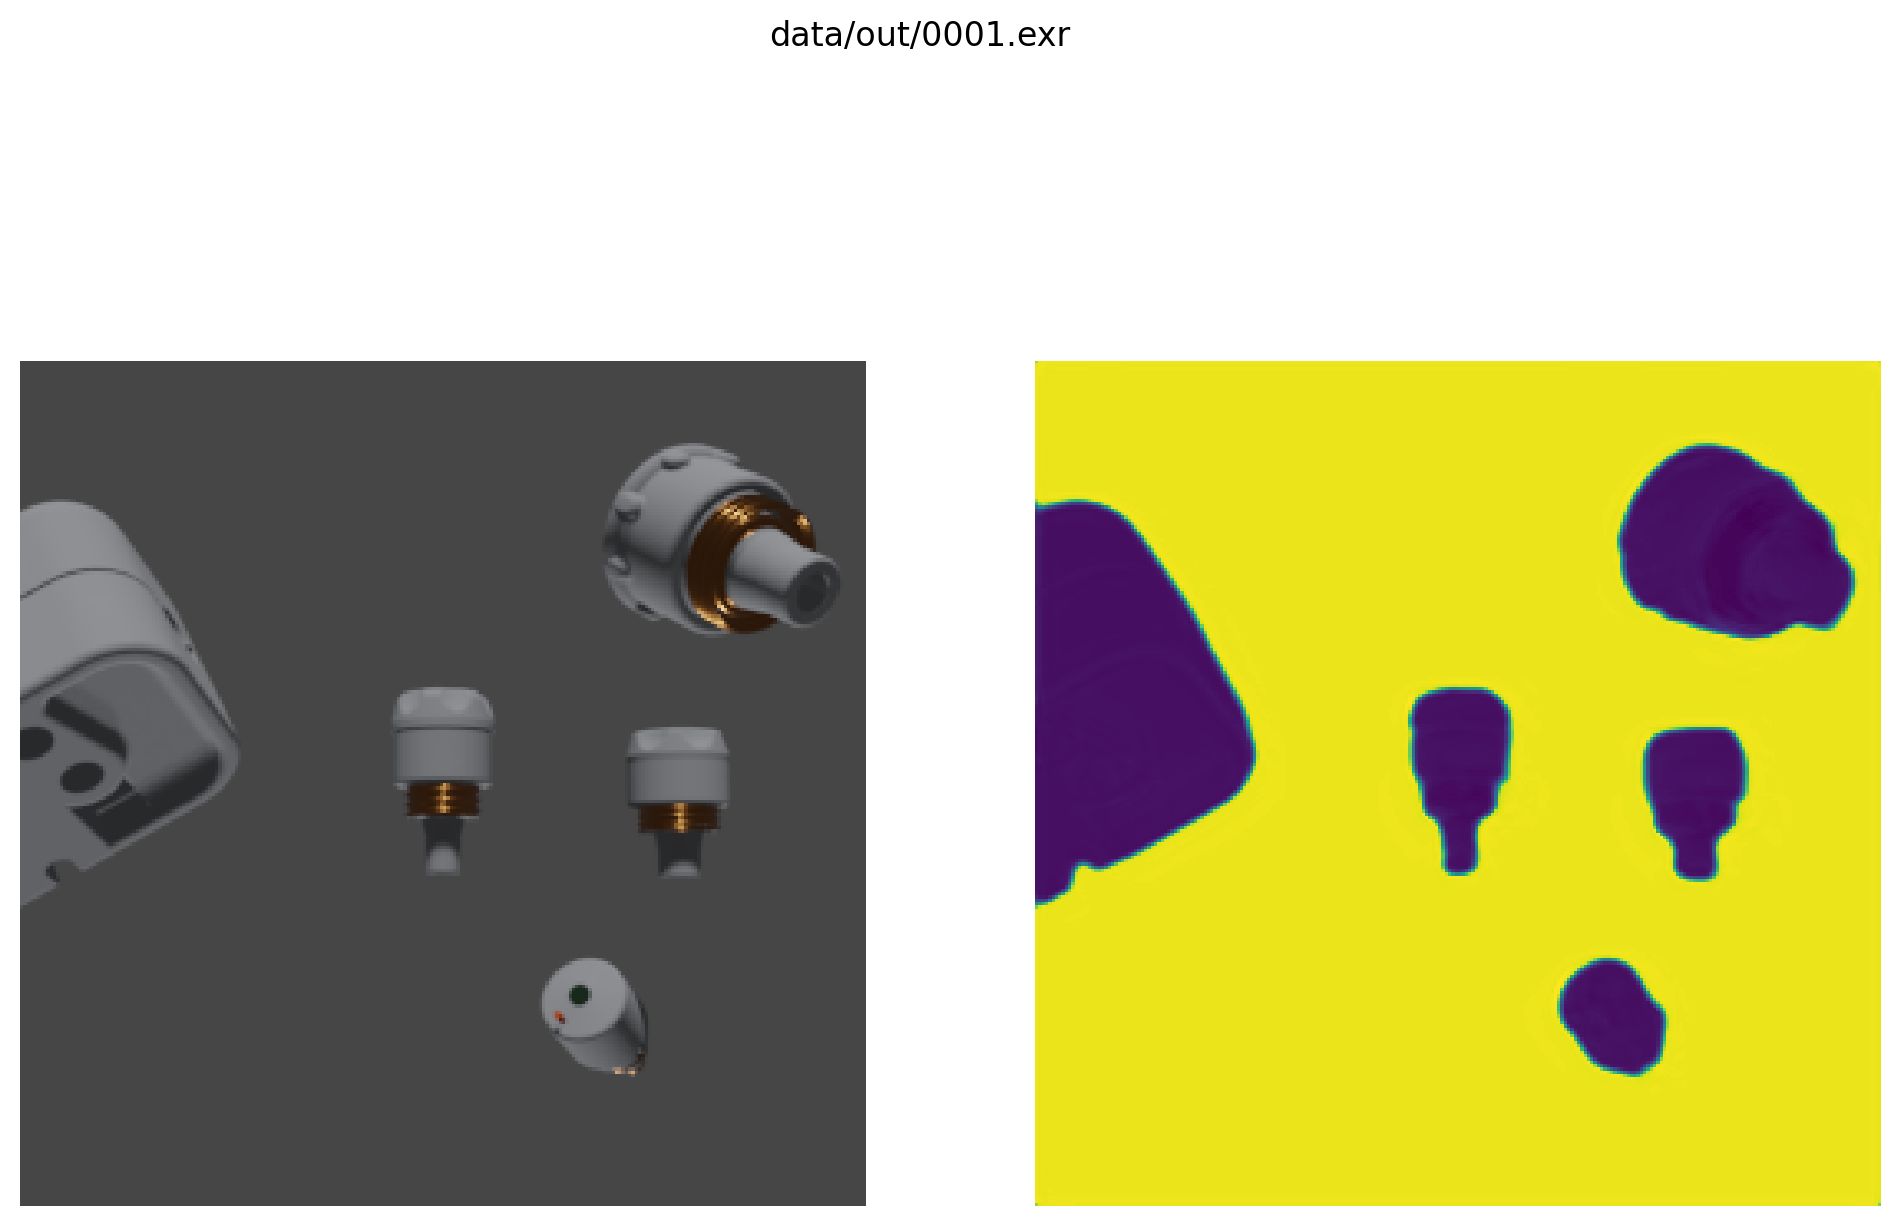

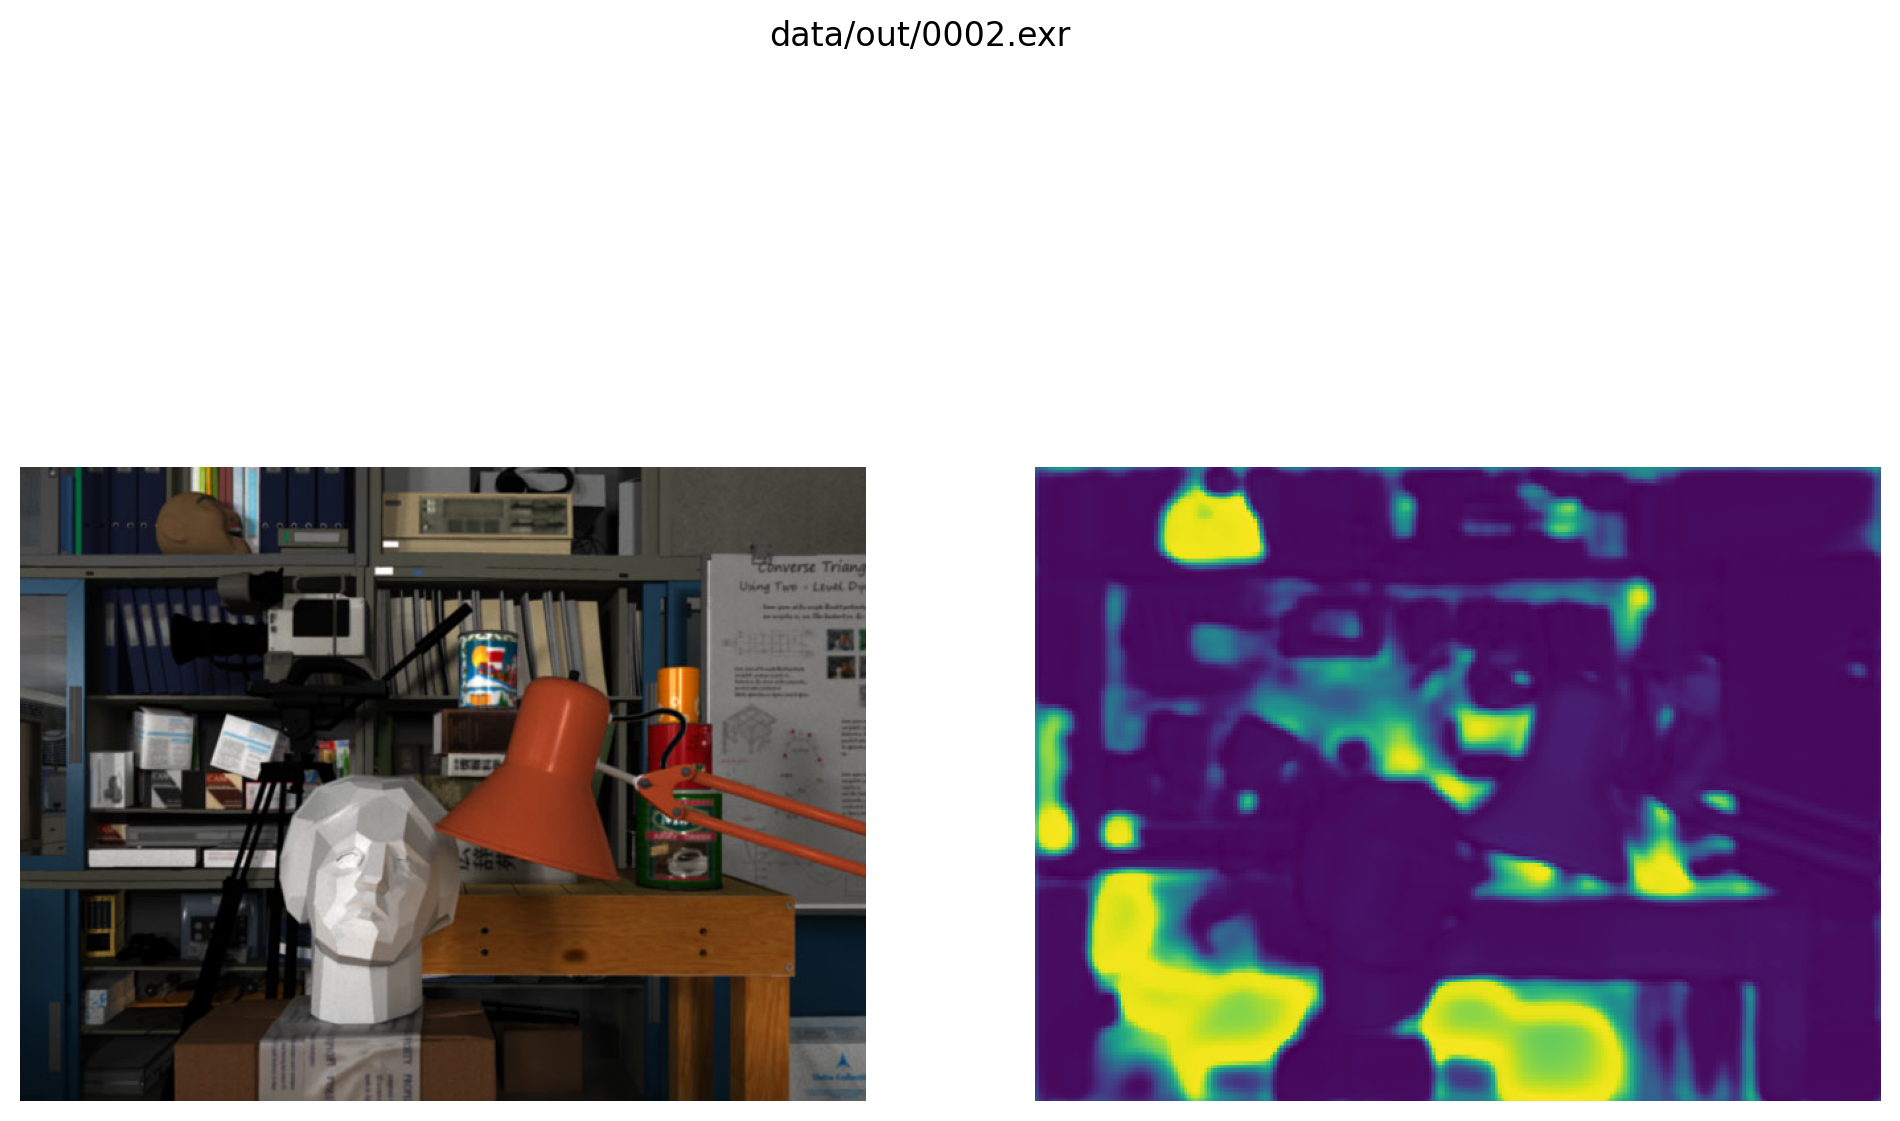

In [11]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions([img], predictions, [path])

In [11]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)